# LiH - Confronti tra metodi UCC ~ 666 min

In [55]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# Array distanze e energie
arr_distance = np.arange(0.75, 4., 0.25) # 13 punti 
arr_ground_energy = {}
arr_intermediate  = {}
arr_results = {}
arr_methods = []
times = {}

## 0 - LiH

In [57]:
from pyscf import gto, scf, fci
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers  import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

In [58]:
def generate_LiH_mol (distance: float = 0.1, basis: str = 'sto3g'):
    LiH = "Li .0 .0 .0; H .0 .0 " + str(distance)
    
    mol = gto.M(
        atom=LiH,
        charge=0,
        spin=0,
        basis=basis,
        symmetry=True,
        verbose=0
    )
    
    driver = PySCFDriver(
        atom=LiH,
        basis=basis, 
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )    
    
    problem = driver.run()
    
    return mol, problem
    
    

### 0.1 - FCI

In [59]:
arr_ground_energy['FCI'] = []
arr_results['FCI'] = []
arr_methods.append('FCI')

def compute_fci_energy (mol):
    # per ciascuna molecola calcolo il campo medio con restricted HF 
    cm  = scf.RHF(mol) # campo medio
    cm.kernel() # questo va runnato a prescindere
    
    # per ciascuna molecola calcolo FCI
    fci_calc = fci.FCI(cm) # <- nei metodi correlati passiamo come argomento un conto di campo medio, HF
    e_FCI = fci_calc.kernel()[0]

    return e_FCI

## 1- UCC Methods

In [60]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC, PUCCD
from qiskit_nature.second_q.mappers import QubitMapper, JordanWignerMapper, ParityMapper

### 1.1 - UCCS

In [61]:
arr_ground_energy['UCCS'] = []
arr_intermediate ['UCCS'] = []
arr_results['UCCS'] = []
arr_methods.append('UCCS')
ini_uccs = None
times['UCCS'] = None

def generate_uccs_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccs = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='s',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccs = [0. for _ in range(uccs.num_parameters)]
    
    return uccs

### 1.2 - UCCD 

In [62]:
arr_ground_energy['UCCD'] = []
arr_intermediate ['UCCD'] = []
arr_results['UCCD'] = []
arr_methods.append('UCCD')
ini_uccd = None
times['UCCD'] = None

def generate_uccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccd = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='d',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccd = [0. for _ in range(uccd.num_parameters)]
    
    return uccd

### 1.3 - UCCSD

In [63]:
arr_ground_energy['UCCSD'] = []
arr_intermediate ['UCCSD'] = []
arr_results['UCCSD'] = []
arr_methods.append('UCCSD')
ini_uccsd = None
times['UCCSD'] = None

def generate_uccsd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    uccsd = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations='sd',
        qubit_mapper=mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_uccsd = [0. for _ in range(uccsd.num_parameters)]
    
    return uccsd

### 1.4 - pUCCD

In [64]:
arr_ground_energy['pUCCD'] = []
arr_intermediate ['pUCCD'] = []
arr_results['pUCCD'] = []
arr_methods.append('pUCCD')
ini_puccd = None
times['pUCCD'] = None

def generate_puccd_ansatz (problem: ElectronicStructureProblem, mapper: QubitMapper = JordanWignerMapper()):
    
    puccd = PUCCD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    
    ini_puccd = [0. for _ in range(puccd.num_parameters)]
    
    return puccd

## 2 - Solver

In [65]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, NFT, L_BFGS_B
from qiskit.primitives import Estimator 
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

In [66]:
# vettori che andranno a raccogliere i risultati delle varie iterazioni dell'algoritmo
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [67]:
def solve_problem (problem: ElectronicStructureProblem, 
                   ansatz: UCC, 
                   intermediate: list = None,
                   ini: np.ndarray = None, 
                   opt=SLSQP(maxiter=1000), 
                   mapper: QubitMapper = JordanWignerMapper()):
    
    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)
    
    if ini is None:
        ini = [0.0] * ansatz.num_parameters
    else:
        vqe_solver.initial_point = ini
    
    calc = GroundStateEigensolver(mapper, vqe_solver)

    res = calc.solve(problem)
    
    # conservo i valori intermedi
    if intermediate is not None:
        intermediate = [counts,values]
    
    
    return res

## 3 - Ex

In [68]:
# Parametri per la risoluzione
opt    = SLSQP(ftol=1E-06, tol=1E-06, eps=1.5E-06)
mapper = JordanWignerMapper()
basis  = 'sto3g'

# Per conservare i tempi di esecuzione
from time import time

In [69]:
for distance in arr_distance:
    print('------------------', distance, '------------------')
    mol, problem = generate_LiH_mol(distance=distance, basis=basis)
    
    # 0 - FCI
    e_FCI = compute_fci_energy(mol=mol)
    arr_ground_energy['FCI'].append(e_FCI)
    
    print('FCI: ', e_FCI)
    
    # 1 - UCCS 
    start_time = time()
    uccs  = generate_uccs_ansatz (problem=problem, mapper=mapper)
    uccs_res = solve_problem(problem=problem,
                             ansatz=uccs, 
                             intermediate=arr_intermediate['UCCS'],
                             ini=ini_uccs,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCS'].append(uccs_res)
    # conservo l'energia
    e_uccs = uccs_res.groundenergy + uccs_res.nuclear_repulsion_energy
    arr_ground_energy['UCCS'].append(e_uccs)
    
    uccs_time = time() - start_time
    print('UCCS: ', e_uccs, ' | time: ', uccs_time)
    
    # 2 - UCCD
    start_time = time()
    uccd  = generate_uccd_ansatz (problem=problem, mapper=mapper)
    uccd_res = solve_problem(problem=problem,
                             ansatz=uccd, 
                             intermediate=arr_intermediate['UCCD'],
                             ini=ini_uccd,
                             opt=opt,
                             mapper=mapper
                            )
    # conservo il result
    arr_results['UCCD'].append(uccd_res)
    # conservo l'energia
    e_uccd = uccd_res.groundenergy + uccd_res.nuclear_repulsion_energy
    arr_ground_energy['UCCD'].append(e_uccd)
    
    uccd_time = time() - start_time
    print('UCCD: ', e_uccd, ' | time: ', uccd_time)
    
    ''' FORSE QUESTO È TROPPO IMPEGNATIVO
    # 3 - UCCSD  
    start_time = time()
    uccsd = generate_uccsd_ansatz(problem=problem, mapper=mapper)
    uccsd_res = solve_problem(problem=problem,
                              ansatz=uccsd, 
                              intermediate=arr_intermediate['UCCSD'],
                              ini=ini_uccsd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['UCCSD'].append(uccsd_res)
    # conservo l'energia
    e_uccsd = uccsd_res.groundenergy + uccsd_res.nuclear_repulsion_energy
    arr_ground_energy['UCCSD'].append(e_uccsd)
    
    uccsd_time = time() - start_time
    print('UCCSD: ', e_uccsd, ' | time: ', uccsd_time)
    '''
    
    # 4 - pUCCD
    start_time = time()
    puccd = generate_puccd_ansatz(problem=problem, mapper=mapper)
    puccd_res = solve_problem(problem=problem,
                              ansatz=puccd, 
                              intermediate=arr_intermediate['pUCCD'],
                              ini=ini_puccd,
                              opt=opt,
                              mapper=mapper
                             )
    # conservo il result
    arr_results['pUCCD'].append(puccd_res)
    # conservo l'energia
    e_puccd = puccd_res.groundenergy + puccd_res.nuclear_repulsion_energy
    arr_ground_energy['pUCCD'].append(e_puccd)
    
    puccd_time = time() - start_time
    print('pUCCD: ', e_puccd, ' | time: ', puccd_time)

FCI:  -7.575486719855826


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.5567208252177505  | time:  38.50250768661499


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.144865111682625  | time:  2623.8296461105347


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.572531653208312  | time:  27.154958963394165
FCI:  -7.784460280031202


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.7673615526779765  | time:  39.84847283363342


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.439296780287164  | time:  1628.9110577106476


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.78148947253342  | time:  40.991652965545654
FCI:  -7.861861440547585


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.71982612362782  | time:  27.77035093307495


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.55524078540466  | time:  1884.601145029068


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.858675360446979  | time:  57.9260151386261
FCI:  -7.882362286798695


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.748105570739249  | time:  30.237790822982788


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.601128974687714  | time:  3384.5792310237885


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.8784302806431254  | time:  33.35940098762512
FCI:  -7.8771870023045025


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.757241697620339  | time:  26.85959005355835


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.615029809136499  | time:  1631.2176840305328


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.8717499605949985  | time:  30.746669054031372
FCI:  -7.861087772481412


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.830904875416687  | time:  56.96859908103943


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.612854305444452  | time:  2069.5927698612213


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.852921994300122  | time:  71.40553903579712
FCI:  -7.841817859457468


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.7526849667103335  | time:  31.691619157791138


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.602267284413702  | time:  1711.4583489894867


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.828908635167847  | time:  31.126244068145752
FCI:  -7.823723883467548


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.798581019541136  | time:  57.426745891571045


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.587104303322935  | time:  2456.2384510040283


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.80291863328535  | time:  26.335015296936035
FCI:  -7.809162297674551


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.792019630414791  | time:  42.099534034729004


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.569282099208283  | time:  6526.438143253326


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.7762001065946  | time:  20.85828995704651
FCI:  -7.798843159502388


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -5.726130044081616  | time:  32.826074838638306


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.549964712257284  | time:  2349.0127539634705


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.749589772271493  | time:  22.99659299850464
FCI:  -7.792184472005113


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.7856715033928605  | time:  60.41572284698486


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.530239497037693  | time:  4759.962714910507


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.7260599739709  | time:  54.52152991294861
FCI:  -7.788115123279003


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -7.784223039615287  | time:  49.89546489715576


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.511368868935606  | time:  5375.176586866379


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.7131773624777855  | time:  25.98714590072632
FCI:  -7.785695170102024


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCS:  -5.720136636245858  | time:  30.73790407180786


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


UCCD:  -5.494667951705363  | time:  2564.1065118312836


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_23050/2123327750.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE( Estimator(), ansatz, opt, callback=store_intermediate_result)


pUCCD:  -7.472981762942466  | time:  31.45937728881836


## 4 - Post-process & plotting

### 4.1 - Qubits, gates, CNOT

In [70]:
# Num qubits
print('Num Qubits:\n')
print('- uccs: ', uccs.num_qubits)
print('- uccd: ', uccd.num_qubits)
print('- uccsd: ', uccsd.num_qubits)
print('- puccd: ', puccd.num_qubits)

Num Qubits:

- uccs:  12
- uccd:  12
- uccsd:  12
- puccd:  12


In [1]:
# Circuit
uccs=uccs.decompose()
uccs.draw('mpl')

NameError: name 'uccs' is not defined

### 4.2 - Plot

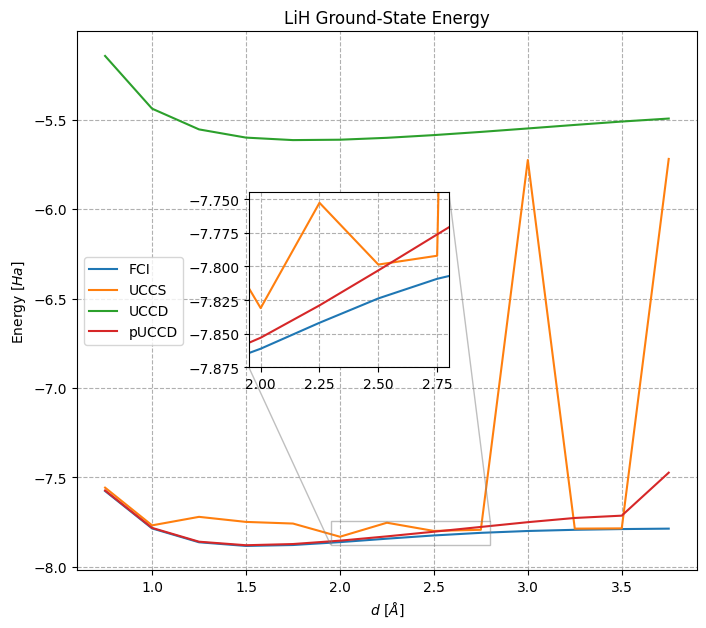

In [89]:
# Zoom sul minimo 1.25<x<1.8 e -7.9<y<-7.85
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met in arr_methods:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset = plt.axes([.34, .4, .25, .25]) 


# Grafico dentro il grafico (zoom)
'''
for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met])
'''

# Imposta i limiti di zoom
ax_inset.axis(xmin=1.95,xmax=2.8)
ax_inset.axis(ymin=-7.875,ymax=-7.745)

for met in arr_methods:  
    ax_inset.plot(arr_distance, arr_ground_energy[met], label=met)


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

plt.show()